In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Loading data
data = np.genfromtxt('train.csv', delimiter=',')
data = data[1:]

In [3]:
# sorting data in Y and X
Y = data[0: ,0]
X = data[0: ,1: ]
print(Y.shape, X.shape)

(42000,) (42000, 784)


In [4]:
# Define image dimensions
img_rows = 28
img_cols = 28
channel = 1

#batch_size to train
batch_size = 256

# number of output classes
nb_classes = 10

# number of epochs to train
nb_epochs = 50

# number of convolutional filters to use
nb_filters_1 = 20
nb_filters_2 = 50

# size of pooling area for max pooling
nb_pool = 2

# convolution kernel size
nb_conv = 3

In [5]:
# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state = 4)

In [6]:
# Using correct dimesntions for input data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

# Assigning X_train and X_test as float
X_train = X_train.astype('float32') 
X_val = X_val.astype('float32')

X_train /= 255
X_val /= 255

# Convert class vectors to binary class matrices
Y_train = to_categorical(Y_train, nb_classes)
Y_val = to_categorical(Y_val, nb_classes)

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(37800, 28, 28, 1) (37800, 10) (4200, 28, 28, 1) (4200, 10)


In [7]:
# Data augmentation
datagen = ImageDataGenerator(zoom_range = 0.1, height_shift_range = 0.1, width_shift_range = 0.1, rotation_range = 10)

In [8]:
# Implementing CNN
model = Sequential()

model.add(Conv2D(nb_filters_1, kernel_size = (nb_conv, nb_conv), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool), strides = (2, 2)))

model.add(Conv2D(nb_filters_2, kernel_size = (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool), strides = (2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(nb_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# Optimizer used is Stochastic Gradient Descent with learning rate of 0.01
# Loss is calculated using categorical cross entropy
opt = 'adam'
ReducedLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1*10**-7)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
filepath="weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 50)        9050      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               640512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________

In [10]:
# Start model training
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=256), steps_per_epoch=len(X_train)//batch_size, epochs=nb_epochs, verbose=1, validation_data = datagen.flow(X_val, Y_val, batch_size=256), validation_steps = len(X_val)//batch_size, callbacks=[ReducedLR, early_stop, checkpoint], shuffle = True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
147/147 [==============================] - 20s 136ms/step - loss: 0.6530 - acc: 0.7885 - val_loss: 0.2139 - val_acc: 0.9326

Epoch 00001: val_loss improved from inf to 0.21394, saving model to weights.best.h5
Epoch 2/50
147/147 [==============================] - 20s 137ms/step - loss: 0.1714 - acc: 0.9472 - val_loss: 0.1155 - val_acc: 0.9642

Epoch 00002: val_loss improved from 0.21394 to 0.11546, saving model to weights.best.h5
Epoch 3/50
147/147 [==============================] - 23s 155ms/step - loss: 0.1182 - acc: 0.9649 - val_loss: 0.1046 - val_acc: 0.9635

Epoch 00003: val_loss improved from 0.11546 to 0.10459, saving model to weights.best.h5
Epoch 4/50
147/147 [==============================] - 23s 160ms/step - loss: 0.0985 - acc: 0.9693 - val_loss: 0.0856 - val_acc: 0.9736

Epoch 00004: val_loss improved from 0.10459 to 0.08558, saving model to weights.best.h5
Epoch 5/50
147/147 [==============================] - 24s 16

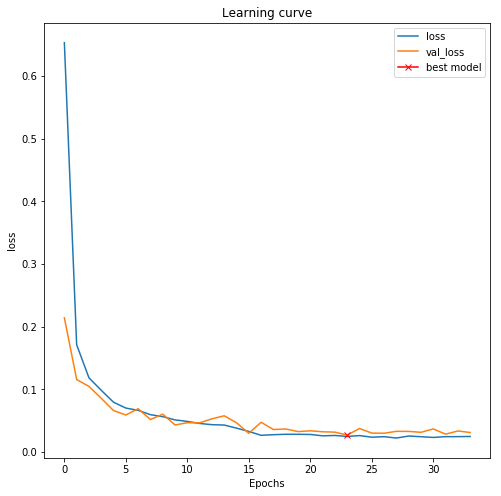

In [11]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss'] 
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [12]:
# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to H5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
# Load model and weights
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("weights.best.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
# Find test loss and accuracy
score = loaded_model.evaluate(X_val, Y_val, verbose=0) # accuracy check
print('Test loss:', score[0], 'Accuracy:', score[1]) 

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# Testing
test_data = np.genfromtxt('test.csv', delimiter = ',')
test_data = test_data[1:]

In [ ]:
print(test_data)

In [ ]:
test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1) 
test_data = test_data.astype('float32')

test_data /= 255

In [ ]:
predictions = loaded_model.predict_classes(test_data)
print(predictions)

In [ ]:
output=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "Label": predictions})
output.to_csv("submission.csv", index=False, header=True)